In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Unzip
!unzip -u "/content/drive/My Drive/data.zip"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: data/positive/55.BMP    
  inflating: data/positive/550.BMP   
  inflating: data/positive/5500.BMP  
  inflating: data/positive/5501.BMP  
  inflating: data/positive/5502.BMP  
  inflating: data/positive/5503.BMP  
  inflating: data/positive/5504.BMP  
  inflating: data/positive/5505.BMP  
  inflating: data/positive/5506.BMP  
  inflating: data/positive/5507.BMP  
  inflating: data/positive/5508.BMP  
  inflating: data/positive/5509.BMP  
  inflating: data/positive/551.BMP   
  inflating: data/positive/5510.BMP  
  inflating: data/positive/5511.BMP  
  inflating: data/positive/5512.BMP  
  inflating: data/positive/5513.BMP  
  inflating: data/positive/5514.BMP  
  inflating: data/positive/5515.BMP  
  inflating: data/positive/5516.BMP  
  inflating: data/positive/5517.BMP  
  inflating: data/positive/5518.BMP  
  inflating: data/positive/5519.BMP  
  inflating: data/positive/552.BMP   
  inflating: data/positive/5520.BMP  
  i

In [5]:
!unzip -u "/content/drive/My Drive/FP_dataset.zip"

Archive:  /content/drive/My Drive/FP_dataset.zip


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.saving import register_keras_serializable
import h5py



target_shape = (200, 200)

In [7]:
def preprocess_image(filename):

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [8]:
anchor_images_path = Path("data/anchor")
positive_images_path = Path("data/positive")
negative_images_path = Path("data/negative")

anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

negative_images = sorted(
    [str(negative_images_path / f) for f in os.listdir(negative_images_path)]
)
image_count = len(anchor_images)


In [9]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [10]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [11]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(6, 6))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

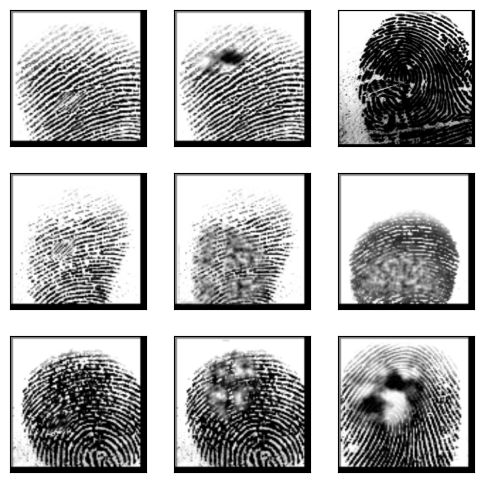

In [12]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [13]:
  base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
class DistanceLayer(layers.Layer):

    def __init__(self, ):
        super().__init__()

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [15]:
@register_keras_serializable()
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)


        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [16]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.00005),metrics=['accuracy'])

In [20]:
history=siamese_model.fit(train_dataset, epochs=7, validation_data=val_dataset)

Epoch 1/7
299/299 [==============================] - ETA: 0s - loss: 0.0047

299/299 [==============================] - 177s 497ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 2/7
299/299 [==============================] - ETA: 0s - loss: 0.0021

299/299 [==============================] - 144s 481ms/step - loss: 0.0021 - val_loss: 8.0376e-04
Epoch 3/7
299/299 [==============================] - ETA: 0s - loss: 0.0027

299/299 [==============================] - 144s 481ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 4/7
299/299 [==============================] - ETA: 0s - loss: 0.0017

299/299 [==============================] - 124s 415ms/step - loss: 0.0017 - val_loss: 1.2515e-04
Epoch 5/7
299/299 [==============================] - ETA: 0s - loss: 2.8638e-04

299/299 [==============================] - 125s 419ms/step - loss: 2.8638e-04 - val_loss: 7.5572e-04
Epoch 6/7
299/299 [==============================] - ETA: 0s - loss: 1.6708e-04

299/299 [==============================] - 139s 465ms/step - loss: 1.6708e-04 - val_loss: 1.8226e-04
Epoch 7/7
299/299 [==============================] - ETA: 0s - loss: 5.5119e-05

299/299 [==============================] - 125s 418ms/step - loss: 5.5119e-05 - val_loss: 3.1079e-04


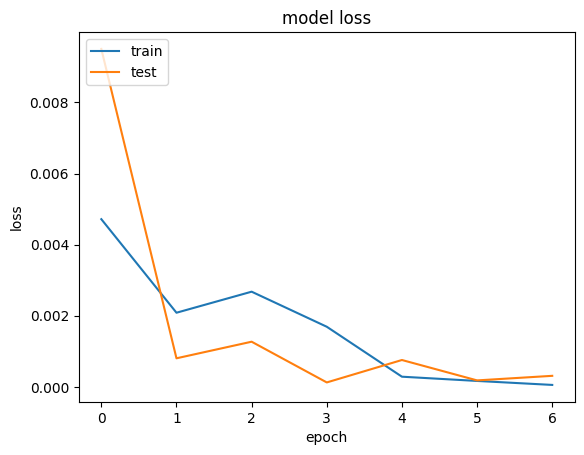

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from scipy.spatial import distance

def preprocess_image(filename):

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def distancebtwembed(path1,path2):
  test_image1 = preprocess_image(path1)
  test_image2 = preprocess_image(path2)

  test_image1 = tf.expand_dims(test_image1, axis=0)
  test_image2 = tf.expand_dims(test_image2, axis=0)

  embedding1 = embedding(test_image1)
  embedding2 = embedding(test_image2)

  embedding1_flat = tf.reshape(embedding1, [256])
  embedding2_flat = tf.reshape(embedding2, [256])

  distance_value = distance.euclidean(embedding1_flat, embedding2_flat)
  return distance_value

#Testing

In [27]:
print(distancebtwembed("/content/012_3_1.jpg","/content/012_3_2.jpg"))

0.3780728578567505


In [28]:
print(distancebtwembed("/content/012_6_3.jpg","/content/012_6_4.jpg"))

0.23805423080921173


In [29]:
print(distancebtwembed("/content/013_4_5.jpg","/content/013_4_6.jpg"))

1.0492329597473145


In [ ]:
import pandas as pd
data = pd.read_csv('test_pairs.csv', delimiter=';\s*', header=None, names=['Path1', 'Path2', 'Label'])

def calculate_accuracy(data):
    correct_predictions = 0
    total_samples = len(data)

    predicted_labels = []

    for index, row in data.iterrows():
        path1 = row['Path1']
        path2 = row['Path2']


        true_label = row['Label']


        similarity_score = distancebtwembed(path1, path2)

        predicted_label = 1 if similarity_score < 0.85 else 0

        if predicted_label == true_label:

            correct_predictions += 1

        predicted_labels.append(predicted_label)

    data['Predicted_Label'] = predicted_labels

    accuracy = correct_predictions / total_samples
    return accuracy
accuracy = calculate_accuracy(data)
print("Accuracy:", accuracy)

<ipython-input-35-3d531ba3b155>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('test_pairs.csv', delimiter=';\s*', header=None, names=['Path1', 'Path2', 'Label'])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(data['Label'], data['Predicted_Label'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()